In [1]:
from importlib.metadata import version

import matplotlib
import tiktoken
import torch

print("matplotlib version:", version("matplotlib"))
print("torch version:", version("torch"))
print("tiktoken version:", version("tiktoken"))

matplotlib version: 3.9.3
torch version: 2.5.1
tiktoken version: 0.8.0


In [2]:
GPT_CONFIG_124M = {
    "vocab_size": 50257,    # Vocabulary size
    "context_length": 1024, # Context length
    "emb_dim": 768,         # Embedding dimension
    "n_heads": 12,          # Number of attention heads
    "n_layers": 12,         # Number of layers
    "drop_rate": 0.1,       # Dropout rate
    "qkv_bias": False       # Query-Key-Value bias
}

In [3]:
768 // 12

64

Remember the `qkv_bias` can be:

$Q = X W_Q + b_Q, \quad K = X W_K + b_K, \quad V = X W_V + b_V$

Using this configuration, we will implement a GPT placeholder architecture (DummyGPTModel), as shown in figure 4.3. This will provide us with a big-picture view of how everything fits together and what other components we need to code to assemble the full GPT model architecture.

<img src="imgs/gpt2order.png" width=40%>

In [4]:
import torch
import torch.nn as nn

In [5]:
import torch
import torch.nn as nn


class DummyGPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])
        
        #1 Uses a placeholder for TransformerBlock
        # -------------------------------------------#

        # Use a placeholder for TransformerBlock
        self.trf_blocks = nn.Sequential(
            *[DummyTransformerBlock(cfg) for _ in range(cfg["n_layers"])])
        
        # -------------------------------------------#

        # 2. Placeholder for LayerNorm
        # -------------------------------------------#
        # Use a placeholder for LayerNorm
        self.final_norm = DummyLayerNorm(cfg["emb_dim"])
        # -------------------------------------------#
        
        # 3. Output head (map from emb dim to vocab size)
        self.out_head = nn.Linear(
            cfg["emb_dim"], cfg["vocab_size"], bias=False
        )

    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
        x = tok_embeds + pos_embeds
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits


class DummyTransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        # A simple placeholder

    def forward(self, x):
        # This block does nothing and just returns its input.
        return x


class DummyLayerNorm(nn.Module):
    def __init__(self, normalized_shape, eps=1e-5):
        super().__init__()
        # The parameters here are just to mimic the LayerNorm interface.

    def forward(self, x):
        # This layer does nothing and just returns its input.
        return x

In [6]:
import tiktoken

tokenizer = tiktoken.get_encoding("gpt2")

batch = []

txt1 = "Every effort moves you"
txt2 = "Every day holds a"

batch.append(torch.tensor(tokenizer.encode(txt1)))
batch.append(torch.tensor(tokenizer.encode(txt2)))
batch = torch.stack(batch, dim=0)
print(batch)

tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])


In [7]:
batch.shape

torch.Size([2, 4])

Next, we initialize a new 124-million-parameter DummyGPTModel instance and feed it the tokenized batch:

In [8]:
torch.manual_seed(123)
model = DummyGPTModel(GPT_CONFIG_124M)

logits = model(batch)

In [9]:
print("Output shape:", logits.shape)

Output shape: torch.Size([2, 4, 50257])


In [10]:
logits

tensor([[[-0.9289,  0.2748, -0.7557,  ..., -1.6070,  0.2702, -0.5888],
         [-0.4476,  0.1726,  0.5354,  ..., -0.3932,  1.5285,  0.8557],
         [ 0.5680,  1.6053, -0.2155,  ...,  1.1624,  0.1380,  0.7425],
         [ 0.0447,  2.4787, -0.8843,  ...,  1.3219, -0.0864, -0.5856]],

        [[-1.5474, -0.0542, -1.0571,  ..., -1.8061, -0.4494, -0.6747],
         [-0.8422,  0.8243, -0.1098,  ..., -0.1434,  0.2079,  1.2046],
         [ 0.1355,  1.1858, -0.1453,  ...,  0.0869, -0.1590,  0.1552],
         [ 0.1666, -0.8138,  0.2307,  ...,  2.5035, -0.3055, -0.3083]]],
       grad_fn=<UnsafeViewBackward0>)

In [12]:
torch.max(logits)

tensor(4.0183, grad_fn=<MaxBackward1>)

In [13]:
torch.min(logits)

tensor(-3.8215, grad_fn=<MinBackward1>)

In [14]:
import numpy as np
import matplotlib.pyplot as plt

In [16]:
# Flatten the tensor to get all the logits values
logits_flat = logits.flatten().detach().numpy()

In [17]:
logits_flat.shape

(402056,)

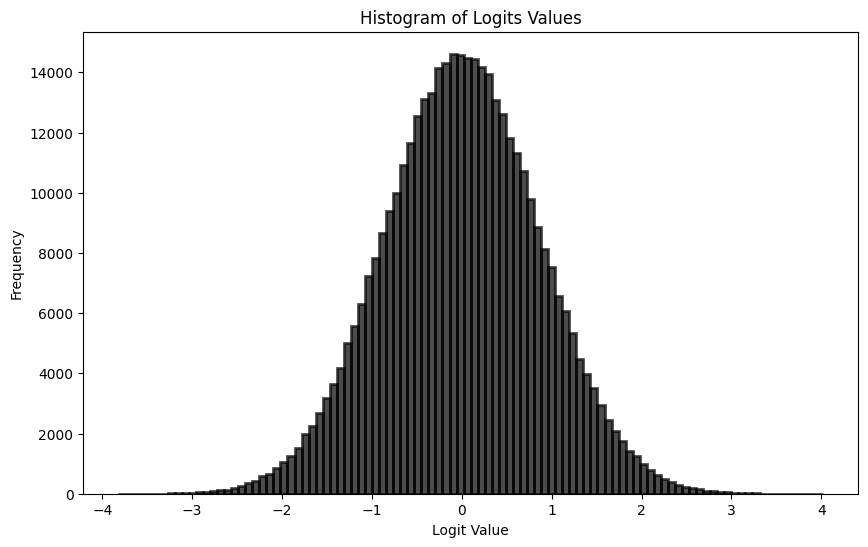

In [21]:
# Create a histogram
plt.figure(figsize=(10, 6))
plt.hist(logits_flat, bins=100, edgecolor='black', linewidth=2, color='black', alpha=0.7)
plt.title('Histogram of Logits Values')
plt.xlabel('Logit Value')
plt.ylabel('Frequency')
plt.show()

The output tensor has two rows corresponding to the two text samples. Each text sample consists of four tokens; each token is a 50,257-dimensional vector, which matches the size of the tokenizer’s vocabulary.

## 4.2 Normalizing activations with layer normalization

Training deep neural networks with many layers can sometimes prove challenging due to problems like vanishing or exploding gradients. 

- The main idea behind layer normalization is to adjust the activations (outputs) of a neural network layer to have a mean of 0 and a variance of 1

**In GPT-2 and modern transformer architectures, layer normalization is typically applied before and after the multi-head attention module and  before the final output layer**

In [22]:
torch.manual_seed(123)

# create 2 training examples with 5 dimensions (features) each
batch_example = torch.randn(2, 5) 

layer = nn.Sequential(nn.Linear(5, 6), nn.ReLU())
out = layer(batch_example)
print(out)

tensor([[0.2260, 0.3470, 0.0000, 0.2216, 0.0000, 0.0000],
        [0.2133, 0.2394, 0.0000, 0.5198, 0.3297, 0.0000]],
       grad_fn=<ReluBackward0>)


In [23]:
batch_example.shape

torch.Size([2, 5])

In [24]:
out.shape

torch.Size([2, 6])

- Let's compute the mean and variance for each of the 2 inputs above:

In [25]:
mean = out.mean(dim=-1, keepdim=True)
var = out.var(dim=-1, keepdim=True)

print("Mean:\n", mean)
print("Variance:\n", var)

Mean:
 tensor([[0.1324],
        [0.2170]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[0.0231],
        [0.0398]], grad_fn=<VarBackward0>)


In [26]:
out.shape

torch.Size([2, 6])

In [27]:
mean.shape

torch.Size([2, 1])

Next, let’s apply layer normalization to the layer outputs we obtained earlier. 

**The operation consists of subtracting the mean and dividing by the square root of the variance (also known as the standard deviation):**

In [28]:
out_norm = (out - mean) / torch.sqrt(var)
mean = out_norm.mean(dim=-1, keepdim=True)
var = out_norm.var(dim=-1, keepdim=True)
print("Normalized layer outputs:\n", out_norm)
print("Mean:\n", mean)
print("Variance:\n", var)

Normalized layer outputs:
 tensor([[ 0.6159,  1.4126, -0.8719,  0.5872, -0.8719, -0.8719],
        [-0.0189,  0.1121, -1.0876,  1.5173,  0.5647, -1.0876]],
       grad_fn=<DivBackward0>)
Mean:
 tensor([[9.9341e-09],
        [1.9868e-08]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


In [29]:
torch.set_printoptions(sci_mode=False)
print("Mean:\n", mean)
print("Variance:\n", var)

Mean:
 tensor([[    0.0000],
        [    0.0000]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


### LayerNorm class

In [30]:
class LayerNorm(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.eps = 1e-5
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))

    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, keepdim=True, unbiased=False)
        norm_x = (x - mean) / torch.sqrt(var + self.eps)
        return self.scale * norm_x + self.shift

Variance is calculated:

$\text{Var}(x) = \frac{1}{N - \delta} \sum_{i=1}^N (x_i - \mu)^2$

Where:

- $N$: Number of elements along the specified dimension.

- $\mu$: Mean of $x$ along the same dimension.

- $\delta$: Adjustment for bias (determines whether the variance is "biased" or "unbiased").


Effect of unbiased:
- `unbiased=True`: Sets $\delta = 1$ so the denominator becomes $N-1$. This provides the unbiased variance estimator (sample variance), commonly used in statistics to estimate the variance of a population from a sample.

- `unbiased=False`: Sets $\delta = 0$ so the denominator is $N$. This gives the biased variance (population variance), often used in machine learning because the entire input (not a sample) is typically used.

What `LayerNorm` does:

$\text{LayerNorm}(x) = \frac{x - \mu}{\sqrt{\sigma^2 + \epsilon}} · \gamma + \beta $

where $\epsilon$ is a small constant added for numerical stability

where $\gamma$ is a learnable parameter called **scale**

where $\beta$ is a learnable parameter called **shift**


The unbiased=False argument in var ensures that the population variance is used when calculating statistics for this single sample's features. This is sufficient since LayerNorm processes one sample's features as the "population."

In [31]:
# NLP Example
batch, sentence_length, embedding_dim = 20, 5, 10

In [32]:
embedding = torch.randn(batch, sentence_length, embedding_dim)

In [33]:
embedding.shape

torch.Size([20, 5, 10])

In [34]:
layer_norm = nn.LayerNorm(embedding_dim)

In images:

In [42]:
# NLP Example
batch, sentence_length, embedding_dim = 20, 5, 10
embedding = torch.randn(batch, sentence_length, embedding_dim)
layer_norm = nn.LayerNorm(embedding_dim)
# Activate module
output = layer_norm(embedding)

# Check the mean and variance of the output
mean = output.mean(dim=-1, keepdim=True)
var = output.var(dim=-1, keepdim=True)

# Flatten for easier visualization
print("Mean of the output:\n", mean.flatten())
print("Variance of the output:\n", var.flatten())

Mean of the output:
 tensor([     0.0000,     -0.0000,      0.0000,      0.0000,     -0.0000,
             0.0000,      0.0000,      0.0000,      0.0000,      0.0000,
            -0.0000,     -0.0000,      0.0000,      0.0000,      0.0000,
            -0.0000,      0.0000,     -0.0000,      0.0000,      0.0000,
             0.0000,      0.0000,      0.0000,     -0.0000,      0.0000,
            -0.0000,      0.0000,      0.0000,     -0.0000,     -0.0000,
            -0.0000,     -0.0000,      0.0000,     -0.0000,     -0.0000,
            -0.0000,      0.0000,     -0.0000,     -0.0000,     -0.0000,
            -0.0000,     -0.0000,      0.0000,      0.0000,      0.0000,
             0.0000,      0.0000,     -0.0000,      0.0000,      0.0000,
            -0.0000,      0.0000,      0.0000,      0.0000,      0.0000,
             0.0000,     -0.0000,     -0.0000,      0.0000,     -0.0000,
             0.0000,     -0.0000,     -0.0000,     -0.0000,     -0.0000,
             0.0000,      0.00

In [43]:
# Image Example
N, C, H, W = 20, 5, 10, 10
input = torch.randn(N, C, H, W)
# Normalize over the last three dimensions (i.e. the channel and spatial dimensions)
# as shown in the image below
layer_norm = nn.LayerNorm([C, H, W])
output = layer_norm(input)

# Check the mean and variance of the output
mean = output.mean(dim=(1, 2, 3), keepdim=True)
var = output.var(dim=(1, 2, 3), keepdim=True)


# Flatten for printing purposes
print("Mean:\n", mean.flatten())
print("Variance:\n", var.flatten())

Mean:
 tensor([    -0.0000,      0.0000,     -0.0000,     -0.0000,      0.0000,
            -0.0000,     -0.0000,     -0.0000,     -0.0000,      0.0000,
            -0.0000,     -0.0000,     -0.0000,     -0.0000,     -0.0000,
            -0.0000,      0.0000,     -0.0000,      0.0000,      0.0000],
       grad_fn=<ViewBackward0>)
Variance:
 tensor([1.0020, 1.0020, 1.0020, 1.0020, 1.0020, 1.0020, 1.0020, 1.0020, 1.0020,
        1.0020, 1.0020, 1.0020, 1.0020, 1.0020, 1.0020, 1.0020, 1.0020, 1.0020,
        1.0020, 1.0020], grad_fn=<ViewBackward0>)


<img src="imgs/layer_norm.jpg" width="200" />

## 4.3 Implementing a feed forward network with GELU activations

Next, we will implement a small neural network submodule used as part of the transformer block in LLMs. We begin by implementing the GELU activation function, which plays a crucial role in this neural network submodule.

 However, in LLMs, several other activation functions are employed beyond the traditional ReLU. Two notable examples are:
 - GELU (Gaussian error linear unit) 
 - SwiGLU (Swish-gated linear unit).


 ### GELU (Gaussian Error Linear Unit):

 $\text{GELU}(x) = x \cdot \Phi(x)$

 where $\Phi(x) = \frac{1}{2} \left( 1 + \text{erf} \left( \frac{x}{\sqrt{2}} \right) \right)$

 an approximation is: $\text{GELU}(x) \approx x \cdot \sigma\left(1.702x\right)$

 where $\sigma(x) = \frac{1}{1 + e^{-x}}$

 ### SwiGLU (Swish-Gated Linear Unit):

$\text{SwiGLU}(x_1, x_2) = x_1 \cdot \text{Swish}(x_2)$

where $x_1, x_2$ are split parts of the input tensor

where $\text{Swish}(x) = x \cdot \sigma(x)$

Expanded this leads to: $\text{SwiGLU}(x_1, x_2) = x_1 \cdot \frac{x_2}{1 + e^{-x_2}}$

In [44]:
class GELU(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(
            torch.sqrt(torch.tensor(2.0 / torch.pi)) * 
            (x + 0.044715 * torch.pow(x, 3))
        ))

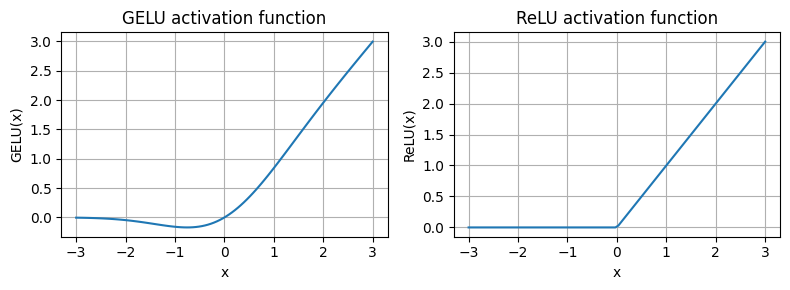

In [45]:
import matplotlib.pyplot as plt
gelu, relu = GELU(), nn.ReLU()

x = torch.linspace(-3, 3, 100)     #1
y_gelu, y_relu = gelu(x), relu(x)
plt.figure(figsize=(8, 3))
for i, (y, label) in enumerate(zip([y_gelu, y_relu], ["GELU", "ReLU"]), 1):
    plt.subplot(1, 2, i)
    plt.plot(x, y)
    plt.title(f"{label} activation function")
    plt.xlabel("x")
    plt.ylabel(f"{label}(x)")
    plt.grid(True)
plt.tight_layout()
plt.show()

The smoothness of GELU can lead to better optimization properties during training, as it allows for more nuanced adjustments to the model’s parameters.

In contrast, ReLU has a sharp corner at zero (figure 4.18, right), which can sometimes make optimization harder, especially in networks that are very deep or have complex architectures.

 -  GELU allows for a small, non-zero output for negative values. This characteristic means that during the training process, **neurons that receive negative input** can still **contribute** to the learning process, albeit to a lesser extent than positive inputs.

### FeedForward Module

In [47]:
class FeedForward(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        emb_dim = cfg["emb_dim"]
        self.layers = nn.Sequential(
            nn.Linear(emb_dim, 4 * emb_dim),
            GELU(),
            nn.Linear(4 * emb_dim, emb_dim),
        )

    def forward(self, x):
        return self.layers(x)

As we can see, the FeedForward module is a small neural network consisting of two Linear layers and a GELU activation function.

In [48]:
ffn = FeedForward(GPT_CONFIG_124M)
x = torch.rand(2, 3, 768)          #1
out = ffn(x)
print(out.shape)

torch.Size([2, 3, 768])


The FeedForward module plays a crucial role in enhancing the model’s ability to learn from and generalize the data.

Although the input and output dimensions of this module are the same, it internally expands the embedding dimension into a higher-dimensional space

This expansion is followed by a nonlinear GELU activation and then a contraction back to the original dimension with the second linear transformation

**Such a design allows for the exploration of a richer representation space.**

<div style="padding: 10px; background-color:rgb(148, 248, 235); border-left: 6px solidrgb(26, 27, 29); border-radius: 5px;">
  <h3 style="margin: 0; color:rgb(18, 18, 19);">🚀 Important Note</h3>
  <p style="color:rgb(15,15,15);"> The uniformity in input and output dimensions  in FFN simplifies the architecture by enabling the stacking of multiple layers, as we will do later, without the need to adjust dimensions between them, thus making the model more scalable.</p>
</div>

## 4.4 Adding shortcut connections (Residual Connections)

If you're writing a technical document, "shortcut connections" or "skip connections" are widely recognized alternatives to "residual connections."

Originally, shortcut connections were proposed for deep networks in computer vision (specifically, in residual networks) to **mitigate the challenge of vanishing gradients**.

 They play a crucial role in preserving the flow of gradients during the backward pass in training.


In [51]:
class ExampleDeepNeuralNetwork(nn.Module):
    def __init__(self, layer_sizes, use_shortcut):
        super().__init__()
        self.use_shortcut = use_shortcut
        self.layers = nn.ModuleList([       #1
            nn.Sequential(nn.Linear(layer_sizes[0], layer_sizes[1]), 
                          GELU()),
            nn.Sequential(nn.Linear(layer_sizes[1], layer_sizes[2]), 
                          GELU()),
            nn.Sequential(nn.Linear(layer_sizes[2], layer_sizes[3]), 
                          GELU()),
            nn.Sequential(nn.Linear(layer_sizes[3], layer_sizes[4]), 
                          GELU()),
            nn.Sequential(nn.Linear(layer_sizes[4], layer_sizes[5]), 
                          GELU())
        ])

    def forward(self, x):
        for layer in self.layers:
            layer_output = layer(x)         #2
            if self.use_shortcut and x.shape == layer_output.shape:    #3
                x = x + layer_output
            else:
                x = layer_output
        return x
    
def print_gradients(model, x):
    # Forward pass
    output = model(x)
    target = torch.tensor([[0.]])

    # Calculate loss based on how close the target
    # and output are
    loss = nn.MSELoss()
    loss = loss(output, target)
    
    # Backward pass to calculate the gradients
    loss.backward()

    for name, param in model.named_parameters():
        if 'weight' in name:
            # Print the mean absolute gradient of the weights
            print(f"{name} has gradient mean of {param.grad.abs().mean().item()}")

In [50]:
layer_sizes = [3, 3, 3, 3, 3, 1]  
sample_input = torch.tensor([[1., 0., -1.]])
torch.manual_seed(123)                            #1
model_without_shortcut = ExampleDeepNeuralNetwork(
    layer_sizes, use_shortcut=False
)

- Gradient values **WITHOUT** RESIDUAL CONNECTIONS

In [52]:
layer_sizes = [3, 3, 3, 3, 3, 1]  

sample_input = torch.tensor([[1., 0., -1.]])

torch.manual_seed(123)
model_without_shortcut = ExampleDeepNeuralNetwork(
    layer_sizes, use_shortcut=False
)
print_gradients(model_without_shortcut, sample_input)

layers.0.0.weight has gradient mean of 0.00020173584925942123
layers.1.0.weight has gradient mean of 0.00012011159560643137
layers.2.0.weight has gradient mean of 0.0007152040489017963
layers.3.0.weight has gradient mean of 0.0013988736318424344
layers.4.0.weight has gradient mean of 0.005049645435065031


- Gradient values **WITH** RESIDUAL CONNECTIONS

In [53]:
torch.manual_seed(123)
model_with_shortcut = ExampleDeepNeuralNetwork(
    layer_sizes, use_shortcut=True
)
print_gradients(model_with_shortcut, sample_input)

layers.0.0.weight has gradient mean of 0.22169791162014008
layers.1.0.weight has gradient mean of 0.20694105327129364
layers.2.0.weight has gradient mean of 0.32896995544433594
layers.3.0.weight has gradient mean of 0.2665732204914093
layers.4.0.weight has gradient mean of 1.3258540630340576


## 4.5 Transformer Block

In [54]:
from scripts.previous_chapters import MultiHeadAttention


class TransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.att = MultiHeadAttention(
            d_in=cfg["emb_dim"],
            d_out=cfg["emb_dim"],
            context_length=cfg["context_length"],
            num_heads=cfg["n_heads"], 
            dropout=cfg["drop_rate"],
            qkv_bias=cfg["qkv_bias"])
        self.ff = FeedForward(cfg)
        self.norm1 = LayerNorm(cfg["emb_dim"])
        self.norm2 = LayerNorm(cfg["emb_dim"])
        self.drop_shortcut = nn.Dropout(cfg["drop_rate"])

    def forward(self, x):
        # Shortcut connection for attention block
        shortcut = x
        x = self.norm1(x)
        x = self.att(x)  # Shape [batch_size, num_tokens, emb_size]
        x = self.drop_shortcut(x)
        x = x + shortcut  # Add the original input back

        # Shortcut connection for feed forward block
        shortcut = x
        x = self.norm2(x)
        x = self.ff(x)
        x = self.drop_shortcut(x)
        x = x + shortcut  # Add the original input back

        return x

In [56]:
torch.manual_seed(123)

x = torch.rand(2, 4, 768)  # Shape: [batch_size, num_tokens, emb_dim]
block = TransformerBlock(GPT_CONFIG_124M)
output = block(x)
output2 = block(output)

print("Input shape:", x.shape)
print("Output shape:", output.shape)
print("Output2 shape:", output2.shape)

Input shape: torch.Size([2, 4, 768])
Output shape: torch.Size([2, 4, 768])
Output2 shape: torch.Size([2, 4, 768])


## GPT Model

In [57]:
class GPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])
        
        self.trf_blocks = nn.Sequential(
            *[TransformerBlock(cfg) for _ in range(cfg["n_layers"])])
        
        self.final_norm = LayerNorm(cfg["emb_dim"])
        self.out_head = nn.Linear(
            cfg["emb_dim"], cfg["vocab_size"], bias=False
        )

    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
        x = tok_embeds + pos_embeds  # Shape [batch_size, num_tokens, emb_size]
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits

In [60]:
import tiktoken

tokenizer = tiktoken.get_encoding("gpt2")

batch = []

txt1 = "Every effort moves you"
txt2 = "Every day holds a"

batch.append(torch.tensor(tokenizer.encode(txt1)))
batch.append(torch.tensor(tokenizer.encode(txt2)))
batch = torch.stack(batch, dim=0)
print(batch)

tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])


In [62]:
batch.shape

torch.Size([2, 4])

In [61]:
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)

out = model(batch)
print("Input batch:\n", batch)
print("\nOutput shape:", out.shape)
print(out)

Input batch:
 tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])

Output shape: torch.Size([2, 4, 50257])
tensor([[[ 0.1381,  0.0077, -0.1963,  ..., -0.0222, -0.1060,  0.1717],
         [ 0.3865, -0.8408, -0.6564,  ..., -0.5163,  0.2369, -0.3357],
         [ 0.6989, -0.1829, -0.1631,  ...,  0.1472, -0.6504, -0.0056],
         [-0.4290,  0.1669, -0.1258,  ...,  1.1579,  0.5303, -0.5549]],

        [[ 0.1094, -0.2894, -0.1467,  ..., -0.0557,  0.2911, -0.2824],
         [ 0.0882, -0.3552, -0.3527,  ...,  1.2930,  0.0053,  0.1898],
         [ 0.6091,  0.4702, -0.4094,  ...,  0.7688,  0.3787, -0.1974],
         [-0.0612, -0.0737,  0.4751,  ...,  1.2463, -0.3834,  0.0609]]],
       grad_fn=<UnsafeViewBackward0>)


In [63]:
batch.shape

torch.Size([2, 4])

In [64]:
out.shape

torch.Size([2, 4, 50257])

- As we see above, this model has 163M, not 124M parameters; why?
- In the original GPT-2 paper, the researchers applied weight tying, which means that they reused the token embedding layer (`tok_emb`) as the output layer, which means setting `self.out_head.weight = self.tok_emb.weight`
- The token embedding layer projects the 50,257-dimensional one-hot encoded input tokens to a 768-dimensional embedding representation
- The output layer projects 768-dimensional embeddings back into a 50,257-dimensional representation so that we can convert these back into words (more about that in the next section)
- So, the embedding and output layer have the same number of weight parameters, as we can see based on the shape of their weight matrices
- However, a quick note about its size: we previously referred to it as a 124M parameter model; we can double check this number as follows:

In [66]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params:,}")

Total number of parameters: 163,009,536


In [67]:
print("Token embedding layer shape:", model.tok_emb.weight.shape)
print("Output layer shape:", model.out_head.weight.shape)

Token embedding layer shape: torch.Size([50257, 768])
Output layer shape: torch.Size([50257, 768])


- In the original GPT-2 paper, the researchers reused the token embedding matrix as an output matrix
- Correspondingly, if we subtracted the number of parameters of the output layer, we'd get a 124M parameter model:

**Input Token Embedding (tok_emb)**

When processing input text, each token (e.g., a word or subword) is mapped to a dense vector representation using a learned embedding matrix $E$, often called the embedding layer.

If the vocabulary size is $V$ and the embedding dimension is $d$, the embedding matrix $E$ has shape:

$E \in \mathbb{R}^{V \times d}$

**Output Layer (out_head)**

At the output, the model predicts a probability distribution over the vocabulary for the next token using a softmax layer. This layer applies a linear transformation using a weight matrix $W$ followed by softmax:

$P(\text{token}) = \text{softmax}(W h + b)$

where $h$ is the hidden state of the last transformer block, $W$ is the output weight matrix of shape $\mathbb{R}^{V \times d}$ and $b$ is the bias.

**Weight Tying**

Instead of learning a separate weight matrix $W$ for the output layer, the same weights from the embedding matrix $E$ are reused:

W = E

In [68]:
total_params_gpt2 =  total_params - sum(p.numel() for p in model.out_head.parameters())
print(f"Number of trainable parameters considering weight tying: {total_params_gpt2:,}")

Number of trainable parameters considering weight tying: 124,412,160


- In practice, I found it easier to train the model without weight-tying, which is why we didn't implement it here
- However, we will revisit and apply this weight-tying idea later when we load the pretrained weights in chapter 5
- Lastly, we can compute the memory requirements of the model as follows, which can be a helpful reference point:

In [69]:
# Calculate the total size in bytes (assuming float32, 4 bytes per parameter)
total_size_bytes = total_params * 4

# Convert to megabytes
total_size_mb = total_size_bytes / (1024 * 1024)

print(f"Total size of the model: {total_size_mb:.2f} MB")

Total size of the model: 621.83 MB


## 4.7 Generating Text